In [180]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
import cv2
import os
from typing import Union
from PIL import ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects
from collections import defaultdict
from sklearn.preprocessing import MultiLabelBinarizer
import random
import pandas as pd
import numpy as np

In [3]:
import torch
import torchvision
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader, Dataset

In [4]:
PATH = Path('./VOCdevkit/VOC2007/')
JSON_PATH = Path('.')

In [5]:
img_size = 224
batch_size = 64

In [6]:
torch.cuda.set_device(2)

In [7]:
annotations = json.load(open(JSON_PATH/'pascal_train2007.json'))
categories = {d['id']:d['name'] for d in annotations['categories']}
categories_bb = categories.copy()
categories_bb[21] = 'background'

In [8]:
categories_bb

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor',
 21: 'background'}

In [9]:
train_bbox_multi_df = pd.read_csv(PATH/'tmp/train_bbox_multi.csv')
val_bbox_multi_df = pd.read_csv(PATH/'tmp/val_bbox_multi.csv')

In [11]:
train_bbox_multi_df.head(10)

,fn,label,bbox
0,VOCdevkit/VOC2007/JPEGImages/000012.jpg,7,155 96 196 174
1,VOCdevkit/VOC2007/JPEGImages/000017.jpg,15 13,184 61 95 138 89 77 314 259
2,VOCdevkit/VOC2007/JPEGImages/000023.jpg,2 2 15 15 15,8 229 237 271 229 219 105 281 1 0 116 369 2 1 ...
3,VOCdevkit/VOC2007/JPEGImages/000026.jpg,7,89 124 248 88
4,VOCdevkit/VOC2007/JPEGImages/000032.jpg,1 1 15 15,103 77 272 106 132 87 65 36 194 179 19 50 25 1...
5,VOCdevkit/VOC2007/JPEGImages/000033.jpg,1 1 1,8 106 491 157 420 199 62 27 324 187 87 36
6,VOCdevkit/VOC2007/JPEGImages/000034.jpg,19 19,115 166 245 234 140 152 193 77
7,VOCdevkit/VOC2007/JPEGImages/000035.jpg,15 15,0 95 191 266 217 97 248 221
8,VOCdevkit/VOC2007/JPEGImages/000036.jpg,12,26 78 293 266
9,VOCdevkit/VOC2007/JPEGImages/000042.jpg,19 19,262 31 238 264 0 35 235 264


# Prior Boxes

In [39]:
import collections
import numpy as np
import itertools

In [40]:
SSDBoxSizes = collections.namedtuple('SSDBoxSizes', ['min', 'max'])

Spec = collections.namedtuple('Spec', ['feature_map_size', 'shrinkage', 'box_sizes', 'aspect_ratios'])

# the SSD orignal specs
specs = [
    Spec(38, 8, SSDBoxSizes(30, 60), [2]),
    Spec(19, 16, SSDBoxSizes(60, 111), [2, 3]),
    Spec(10, 32, SSDBoxSizes(111, 162), [2, 3]),
    Spec(5, 64, SSDBoxSizes(162, 213), [2, 3]),
    Spec(3, 100, SSDBoxSizes(213, 264), [2]),
    Spec(1, 300, SSDBoxSizes(264, 315), [2])
]

In [51]:
def generate_ssd_priors(specs, image_size=300, clip=True):
    """Generate SSD Prior Boxes.
    
    Args:
        specs: Specs about the shapes of sizes of prior boxes. i.e.
            specs = [
                Spec(38, 8, SSDBoxSizes(30, 60), [2]),
                Spec(19, 16, SSDBoxSizes(60, 111), [2, 3]),
                Spec(10, 32, SSDBoxSizes(111, 162), [2, 3]),
                Spec(5, 64, SSDBoxSizes(162, 213), [2, 3]),
                Spec(3, 100, SSDBoxSizes(213, 264), [2]),
                Spec(1, 300, SSDBoxSizes(264, 315), [2])
            ]
        image_size: image size.
    
    Returns:
        priors: a list of priors: [[center_x, center_y, h, w]]. All the values
                are relative to the image size (300x300).
                
    Source: https://medium.com/@smallfishbigsea/understand-ssd-and-implement-your-own-caa3232cd6ad
    """
    boxes = []
    for spec in specs:
        scale = image_size / spec.shrinkage
        for j, i in itertools.product(range(spec.feature_map_size), repeat=2):
            x_center = (i + 0.5) / scale
            y_center = (j + 0.5) / scale

            # small sized square box
            size = spec.box_sizes.min
            h = w = size / image_size
            boxes.append([
                x_center,
                y_center,
                h,
                w
            ])
            
            # big sized square box
            size = np.sqrt(spec.box_sizes.max * spec.box_sizes.min)
            h = w = size / image_size
            boxes.append([
                x_center,
                y_center,
                h,
                w
            ])           
            
            # change h/w ratio of the small sized box
            # based on the SSD implementation, it only applies ratio to the smallest size.
            # it looks weird.
            size = spec.box_sizes.min
            h = w = size / image_size
            for ratio in spec.aspect_ratios:
                ratio = np.sqrt(ratio)                  
                boxes.append([
                    x_center,
                    y_center,
                    h * ratio,
                    w / ratio
                ])
                boxes.append([
                    x_center,
                    y_center,
                    h / ratio,
                    w * ratio
                ])
    boxes = np.array(boxes)
    if clip:
        boxes = np.clip(boxes, 0.0, 1.0)
        
    return boxes

In [52]:
boxes = generate_ssd_priors(specs, image_size=300, clip=True)

In [53]:
boxes.shape

(8732, 4)

In [54]:
boxes

array([[0.01333333, 0.01333333, 0.1       , 0.1       ],
       [0.01333333, 0.01333333, 0.14142136, 0.14142136],
       [0.01333333, 0.01333333, 0.14142136, 0.07071068],
       ...,
       [0.5       , 0.5       , 0.96124919, 0.96124919],
       [0.5       , 0.5       , 1.        , 0.62225397],
       [0.5       , 0.5       , 0.62225397, 1.        ]])

In [152]:
# make dictionary {img_id:[(cat_id, bbox), (cat_id, bbox), ...]}
def make_anno_dict(anno_json):
    anno_dict = defaultdict(list)
    for anno in anno_json['annotations']:
        if not anno['ignore']:
    #         bb = bounding_box(anno['bbox'])
            bb = np.array(anno['bbox'])  # matplotlib accepts VOC format bounding box, so no need to convert
            anno_dict[anno['image_id']].append(
                (anno['category_id'], bb))
    return anno_dict


def load_image(img_path):
    img = cv2.imread(str(img_path)).astype(np.float32)/255
    print(img.shape)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb


def show_img(im, figsize=None, ax=None):
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    return ax


def draw_outline(plt_object, lw):
    plt_object.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])


def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(
        b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)


def draw_text(ax, xy, txt, font_sz=14):
    text = ax.text(*xy, txt,
                   verticalalignment='top', color='white', fontsize=font_sz, weight='bold')
    draw_outline(text, 1)

def show_by_index(idx:int, annotations:dict):
    img_path = str(IMG_PATH/f'{idx:06d}.jpg')
    img = load_image(img_path)
    
    if idx in annotations.keys():
        print(img_path)
        ax = show_img(img, figsize=(12, 12))
        for item in annotations[idx]:
            b = item[1]
            print(f'Bounding box:\nX: {b[0]}\nY: {b[1]}\nWidth: {b[2]}\nHeight: {b[3]}')
            draw_rect(ax, b)
            draw_text(ax, b[:2], categories[item[0]])

In [153]:
def hw_center(bb):
    """Given x-y-width-height format return cx-cy-height-width format."""
    w, h = bb[2], bb[3]
    cx = bb[0] + w/2
    cy = bb[1] + h/2
    return np.array([cx, cy, h, w])


def center_hw(bb):
    """Given cx-cy-height-width format return x-y-width-height format."""
    w, h = bb[3], bb[2]
    x = bb[0] - w/2
    y = bb[1] - h/2
    return np.array([x, y, w, h])

7219
(500, 375, 3)
VOCdevkit/VOC2007/JPEGImages/007219.jpg
Bounding box:
X: 132
Y: 184
Width: 99
Height: 89
Bounding box:
X: 0
Y: 338
Width: 224
Height: 162


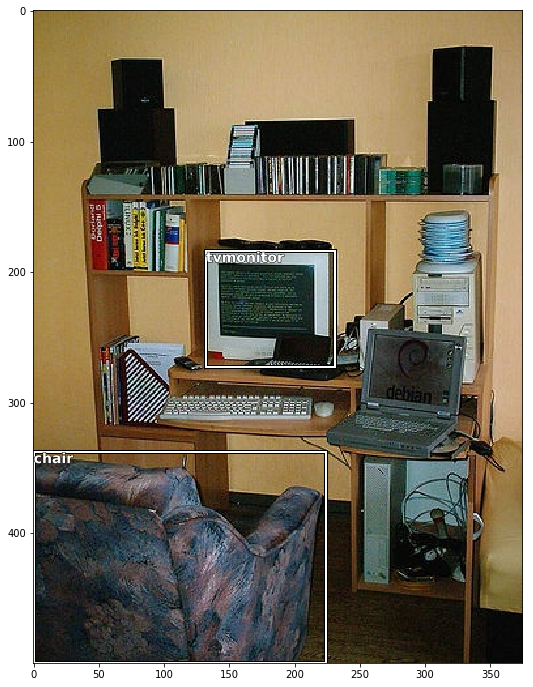

In [161]:
IMG_PATH = PATH/'JPEGImages'
annotations = json.load(open('./pascal_train2007.json'))
train_anno = make_anno_dict(annotations)
img_ids = list(train_anno.keys())
idx = random.sample(img_ids, 1)[0]
print(idx)
show_by_index(idx, train_anno)

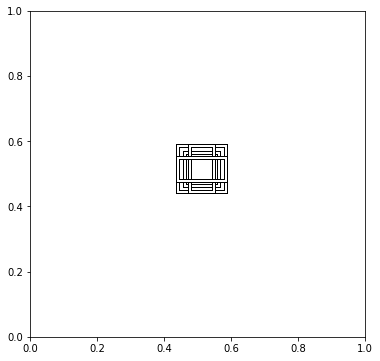

In [82]:
fig, ax = plt.subplots(figsize=(6, 6))
for b in boxes[:4]:
    b = [b[0]+0.5-b[3]/2, b[1]+0.5-b[2]/2, b[3], b[2]]
    draw_rect(ax, b)
plt.show()

In [83]:
boxes[:4]

array([[0.01333333, 0.01333333, 0.1       , 0.1       ],
       [0.01333333, 0.01333333, 0.14142136, 0.14142136],
       [0.01333333, 0.01333333, 0.14142136, 0.07071068],
       [0.01333333, 0.01333333, 0.07071068, 0.14142136]])

In [85]:
boxes[4:8]

array([[0.04      , 0.01333333, 0.1       , 0.1       ],
       [0.04      , 0.01333333, 0.14142136, 0.14142136],
       [0.04      , 0.01333333, 0.14142136, 0.07071068],
       [0.04      , 0.01333333, 0.07071068, 0.14142136]])

In [102]:
boxes[6004:6010]

array([[0.02666667, 0.13333333, 0.2       , 0.2       ],
       [0.02666667, 0.13333333, 0.27202941, 0.27202941],
       [0.02666667, 0.13333333, 0.28284271, 0.14142136],
       [0.02666667, 0.13333333, 0.14142136, 0.28284271],
       [0.02666667, 0.13333333, 0.34641016, 0.11547005],
       [0.02666667, 0.13333333, 0.11547005, 0.34641016]])

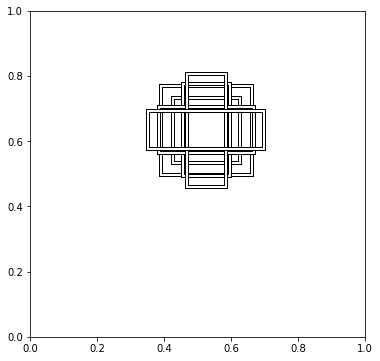

In [103]:
fig, ax = plt.subplots(figsize=(6, 6))
for b in boxes[6004:6010]:
    b = [b[0]+0.5-b[3]/2, b[1]+0.5-b[2]/2, b[3], b[2]]
    draw_rect(ax, b)
plt.show()

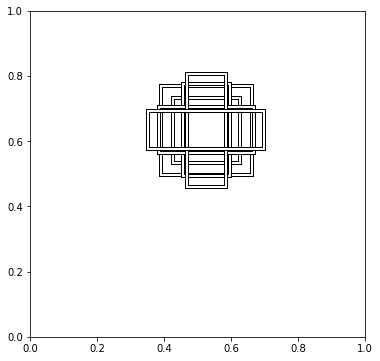

In [118]:
fig, ax = plt.subplots(figsize=(6, 6))
for b in boxes[6004:6010]:
    b = center_hw(b)
    b = [b[0]+0.5, b[1]+0.5, b[2], b[3]]
    draw_rect(ax, b)
plt.show()

In [136]:
def area_of(left_top, right_bottom) -> torch.Tensor:
    """Compute the areas of rectangles given two corners.
    Args:
        left_top (N, 2): left top corner (x, y).
        right_bottom (N, 2): right bottom corner (x+width, y+height).
    Returns:
        area (N): return the area.
    """
    hw = torch.clamp(right_bottom - left_top, min=0.0)
    return hw[:, 0] * hw[:, 1]


def iou_of(gt, pred, epsilon=1e-5):
    """Return intersection-over-union (Jaccard index) of boxes.
    Args:
        gt (N, 4): ground truth boxes.
        pred (N or 1, 4): predicted boxes.
        epsilon: a small number to avoid 0 as denominator.
    Returns:
        iou (N): IoU values.
    """
    overlap_left_top = torch.max(gt[:, :2], pred[:, :2])
    overlap_right_bottom = torch.min(gt[:, 2:], pred[:, 2:])

    overlap_area = area_of(overlap_left_top, overlap_right_bottom)
    area_gt = area_of(gt[:, :2], gt[:, 2:])
    area_pred = area_of(pred[:, :2], pred[:, 2:])
    return overlap_area / (area_gt + area_pred - overlap_area + epsilon)

In [178]:
def match_prior_with_truth(gt_boxes, gt_labels, priors, iou_threshold):
    """ Match the prior box with ground-truth bounding boxes.
    (1) for every ground-truth box:
            match the ground-truth box with prior having the biggest IoU  
    (2) for every prior:
            ious = IoU(prior, ground_truth_boxes)
            max_iou = max(ious)
            if max_iou > threshold:
                i = argmax(ious)
                match the prior with ground_truth_boxes[i]
    Args:
        gt_boxes (num_targets, 4): ground truth boxes.
        gt_labels (num_targets): labels of targets.
        priors (num_priors, 4): corner form, (left_top, right_bottom)
    
    Returns:
        boxes (num_priors, 4): real values for priors.
        labels (num_priros): labels for priors.
    """
    # size: num_priors x num_targets
    ious = iou_of(gt_boxes.unsqueeze(0), corner_form_priors.unsqueeze(1))
    # size: num_priors
    best_target_per_prior, best_target_per_prior_index = ious.max(1)
    # size: num_targets
    best_prior_per_target, best_prior_per_target_index = ious.max(0)
    
    for target_index, prior_index in enumerate(best_prior_per_target_index):
        best_target_per_prior_index[prior_index] = target_index
        
    # 2.0 is used to make sure every target has a prior assigned
    best_target_per_prior.index_fill_(0, best_prior_per_target_index, 2)
    
    # size: num_priors
    labels = gt_labels[best_target_per_prior_index]
    labels[best_target_per_prior < iou_threshold] = 20  # the backgournd id
    boxes = gt_boxes[best_target_per_prior_index]
    
    return boxes, labels

# Hard Negative Mining

The huge number of priors labelled as background would make the dataset very unbalanced, so we usually use the method called **"Hard Negative Mining"** to make the dataset more balanced. The idea is only count the background priors with highest confidence into the computation of total loss function. The others are ignored.

In [179]:
def hard_nm(box_scores, iou_threshold, top_k=-1, candidate_size=200):
    """
    Args:
        box_scores (N, 5): boxes in corner-form and probabilities.
        iou_threshold: intersection over union threshold.
        top_k: keep top_k results. If k <= 0, keep all the results.
        candidate_size: only consider the candidates with the highest scores.
    Returns:
         boxes_to_keep: a list of indexes of the kept boxes
    """
    scores = box_scores[:, -1]
    boxes = box_scores[:, :-1]
    boxes_to_keep = []
    _, indexes = scores.sort(descending=True)
    indexes = indexes[:candidate_size]
    while len(indexes) > 0:
        current = indexes[0]
        boxes_to_keep.append(current.item())
        if 0 < top_k == len(boxes_to_keep) or len(indexes) == 1:
            break
        current_box = boxes[current, :]
        indexes = indexes[1:]
        rest_boxes = boxes[indexes, :]
        iou = iou_of(
            rest_boxes,
            current_box.unsqueeze(0),
        )
        indexes = indexes[iou <= iou_threshold]

    return box_scores[boxes_to_keep, :]